In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))


import tensorflow as tf
import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.models import Sequential

from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.summary_networks import DeepSet, HierarchicalNetwork, SetTransformer

from src.networks import AmortizedMixture, AmortizedPosteriorMixture
from src.models.MixtureNormal import model, modelFixedContext, configurator, constrain_parameters, unconstrain_parameters, constrained_parameter_names, generate_fixed_dataset
from amortizer import amortizer
from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 230, 5)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_100.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
stan_model = CmdStanModel(stan_file="../../stan/mixture-normal.stan")

In [3]:
true_params = np.array([[0.3, 0.5, 0.2, -1.8, -0.5, 1.2]])

df = modelFixedContext(n_obs=200, n_rep=3).simulator(true_params)
df['prior_draws'] = true_params
df['sim_non_batchable_context'] = np.array([200, 3])

# reorder data points based on their means
ind =df['sim_data'][:,:,:-1]
ind = np.argsort(np.mean(ind, axis=-1)[0])
df['sim_data'] = df['sim_data'][:,ind]

df = configurator(df)

observables = df['posterior_inputs']['summary_conditions'][0,...,0]
means = np.array(np.mean(observables, axis=-1))
latents = np.array(df['mixture_inputs']['latents'][0,0])

stan_df = {
    "n_obs": 200,
    "n_cls": 3,
    "n_rep": 3,
    "y": observables,
    "mu_prior": [-2.0, 0.0, 2.0],
    "mixture_prior": [2, 2, 2]
}

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 200, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.


In [4]:
bf_unconstrained_posterior, bf_class_membership = amortizer.sample(df, n_samples=4000)
bf_unconstrained_posterior = bf_unconstrained_posterior[0]
bf_class_membership = bf_class_membership[0]
bf_posterior = constrain_parameters(bf_unconstrained_posterior)

In [5]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptojlcpvt/mixture-normalfdqv5x4q/mixture-normal-20240807082047_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptojlcpvt/mixture-normalfdqv5x4q/mixture-normal-20240807082047_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptojlcpvt/mixture-normalfdqv5x4q/mixture-normal-20240807082047_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptojlcpvt/mixture-normalfdqv5x4q/mixture-normal-20240807082047_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [6]:
stan_posterior = stan_fit.draws_pd(vars = ["p", "mu"])
stan_posterior = np.array(stan_posterior)

In [7]:
# if desired, test how the mixture network performs with the parameter samples from Stan
# df['mixture_inputs']['parameters'] = np.expand_dims(unconstrain_parameters(stan_posterior), axis=0).astype(np.float32)
# bf_class_membership = amortizer.amortized_mixture.sample(df['mixture_inputs'])
# bf_class_membership = bf_class_membership[0]

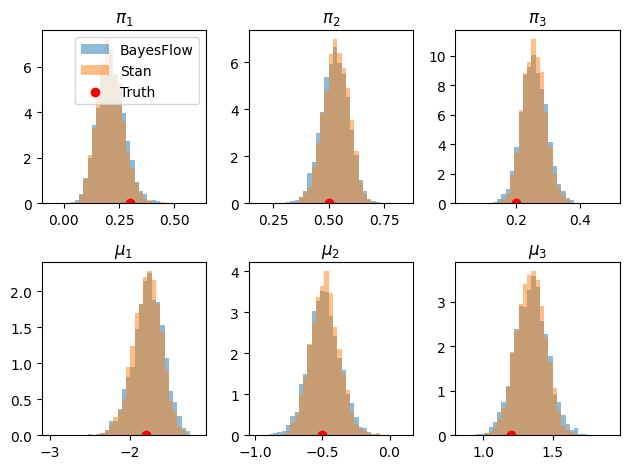

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3)
plt.rcParams['figure.figsize'] = [8, 6]

axs = axs.flatten()

bins = [
    np.linspace(np.min(bf_posterior[:,i])-0.1, np.max(bf_posterior[:,i])+0.1, 36) for i in range(6)
]
for i, par in enumerate(constrained_parameter_names):
    axs[i].hist(bf_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="BayesFlow")
    axs[i].hist(stan_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="Stan")
    axs[i].scatter(true_params[0,i], 0, color="red", label="Truth")
    axs[i].set_title(par)

axs[0].legend()
fig.tight_layout()

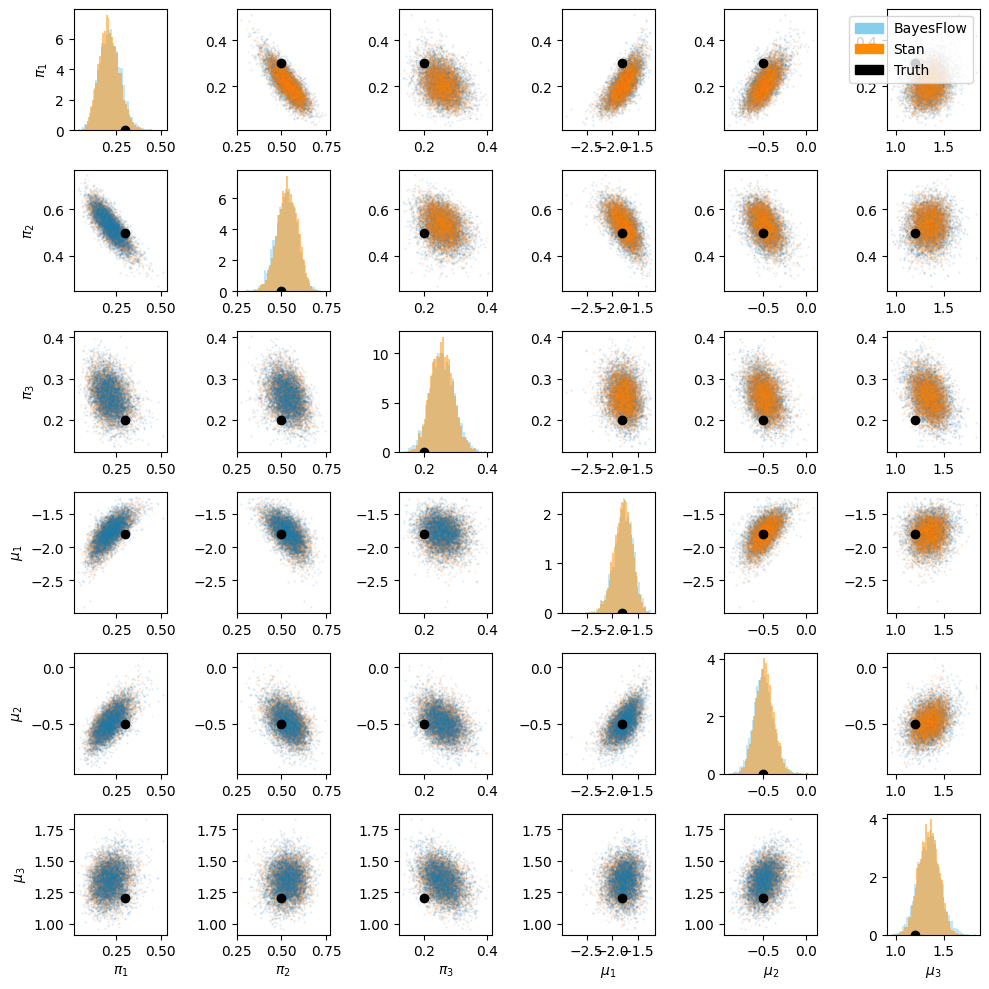

In [13]:
fig, axs = plt.subplots(nrows=len(constrained_parameter_names), ncols=len(constrained_parameter_names))
plt.rcParams['figure.figsize'] = [10, 10]

bins = [
    np.linspace(np.min(bf_posterior[:,i])-0.1, np.max(bf_posterior[:,i])+0.1, 36) for i in range(6)
]

handles = [
    patches.Patch(color='skyblue'),
    patches.Patch(color='darkorange'),
    patches.Patch(color='black')
]
for xi, x_par in enumerate(constrained_parameter_names):
    axs[-1,xi].set_xlabel(x_par)
    for yi, y_par in enumerate(constrained_parameter_names):
        if xi == yi:
            axs[yi,0].set_ylabel(y_par)
            axs[yi,xi].hist(bf_posterior[:,xi], bins=40,alpha = 0.5, density=True, color="skyblue")
            axs[yi,xi].hist(stan_posterior[:,xi], bins=40,alpha = 0.5, density=True, color="darkorange")
            axs[yi,xi].scatter(true_params[0,xi], 0, color="black", label="Truth")
        elif xi > yi:
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, label="skyblue")
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, label="darkorange")
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color="black")
        else:
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, label="skyblue", zorder=2)
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, label="darkorange",zorder=1)
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color="black", zorder=3)

axs[0,-1].legend(handles, ["BayesFlow", "Stan", "Truth"])
fig.tight_layout()

In [10]:
stan_class_membership = stan_fit.stan_variables()["class_membership"]

losses = {
    "stan": amortizer.amortized_mixture.loss(np.tile(np.expand_dims(latents, 0), (4000, 1, 1)), stan_class_membership),
    "bf": amortizer.amortized_mixture.loss(np.tile(np.expand_dims(latents, 0), (4000, 1, 1)), bf_class_membership)
}
losses

{'stan': <tf.Tensor: shape=(), dtype=float64, numpy=0.7170183792703216>,
 'bf': <tf.Tensor: shape=(), dtype=float32, numpy=0.7181319>}

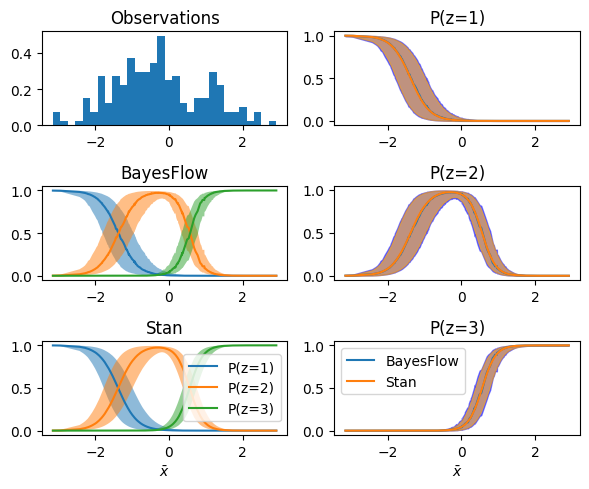

In [25]:
fig, axs = plt.subplots(3, 2)
plt.rcParams['figure.figsize'] = [6, 5]

axs[0,0].hist(means, bins=30, density=True)

axs[0,0].set_title("Observations")
axs[1,0].set_title("BayesFlow")
axs[2,0].set_title("Stan")

for cls in range(3):
    axs[1,0].plot(means, np.median(bf_class_membership[...,cls], axis=0))
    axs[1,0].fill_between(
        means,
        np.quantile(bf_class_membership[...,cls], q=0.025, axis=0),
        np.quantile(bf_class_membership[...,cls], q=0.975, axis=0),
        alpha=0.5
    )

    axs[2,0].plot(means, np.median(stan_class_membership[...,cls], axis=0),label="P(z={})".format(cls+1))
    axs[2,0].fill_between(
        means,
        np.quantile(stan_class_membership[...,cls], q=0.025, axis=0),
        np.quantile(stan_class_membership[...,cls], q=0.975, axis=0),
        alpha=0.5
    )


for cls in range(3):
    axs[cls,1].set_title("P(z={})".format(cls+1))
    axs[cls,1].plot(means, np.median(bf_class_membership[...,cls], axis=0), label="BayesFlow")
    axs[cls,1].fill_between(
        means,
        np.quantile(bf_class_membership[...,cls], q=0.025, axis=0),
        np.quantile(bf_class_membership[...,cls], q=0.975, axis=0),
        alpha=0.5,
        color="blue"
    )
    
    axs[cls,1].plot(means, np.median(stan_class_membership[...,cls], axis=0), label="Stan")
    axs[cls,1].fill_between(
        means,
        np.quantile(stan_class_membership[...,cls], q=0.025, axis=0),
        np.quantile(stan_class_membership[...,cls], q=0.975, axis=0),
        alpha=0.5,
        color="orange"
    )
axs[-1,0].set_xlabel(r"$\bar{x}$")
axs[-1,1].set_xlabel(r"$\bar{x}$")


axs[-1,0].legend()
axs[-1,1].legend()
fig.tight_layout()
